# Подготовка и импорт библиотек

In [86]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

## Магическая команда для jupyter, чтобы графики были внутри


In [87]:
%matplotlib inline

## Константы из методички

In [88]:
FX = 575.7
FY = 575.7
CX = 320
CY = 240

# Работа с картой глубины

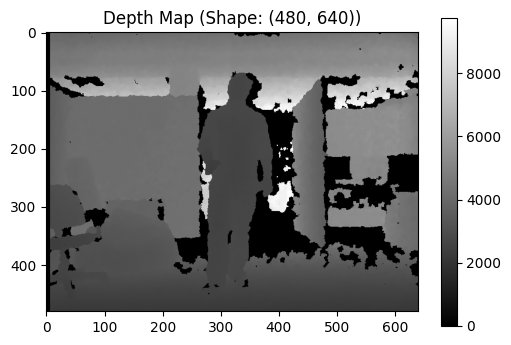

In [89]:
img_path = "dot_cloud.png"
depthmap = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)

if depthmap is None:
    print("Ошибка: Файл не найден.")
else:
    plt.figure(figsize=(6, 4))
    plt.imshow(depthmap, cmap='gray')
    plt.title(f"Depth Map (Shape: {depthmap.shape})")
    plt.colorbar()
    plt.show()

## Преобразование в облако точек (Быстрый способ)

In [90]:
def depthmap_to_pointcloud(depthmap):
    # Создаем сетку индексов
    grid = np.indices(depthmap.shape)
    v = grid[0].flatten()
    u = grid[1].flatten()
    z = depthmap.flatten()

    # Фильтруем нулевые значения (фон)
    valid = z > 0
    z = z[valid]
    u = u[valid]
    v = v[valid]

    # Формулы из лекции:
    # x = z * (u - cx) / fx
    # y = z * (cy - v) / fy  (обрати внимание на порядок cy - v)
    x = z * (u - CX) / FX
    y = z * (CY - v) / FY

    points = np.stack([x, y, z], axis=1)
    return points

In [91]:
if depthmap is not None:
    points_3d = depthmap_to_pointcloud(depthmap)
    print(f"Сгенерировано точек: {points_3d.shape[0]}")

Сгенерировано точек: 261916


# Визуализация 3D и проекций

In [92]:
def plot_3d(points, skip=10):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Берем каждую 10-ю точку
    p = points[::skip]
    ax.scatter(p[:,0], p[:,1], p[:,2], s=0.1, c=p[:,2], cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [93]:
def plot_projections(points):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # XY
    ax[0].plot(points[:,0], points[:,1], ',', alpha=0.2)
    ax[0].set_title("Проекция XY")
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")

    # XZ (Вид сверху)
    ax[1].plot(points[:,0], points[:,2], ',', alpha=0.2)
    ax[1].set_title("Проекция XZ")
    ax[1].set_xlabel("X")
    ax[1].set_ylabel("Z")

    plt.show()

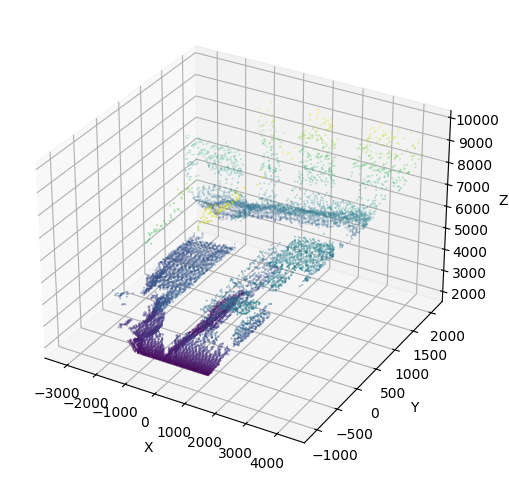

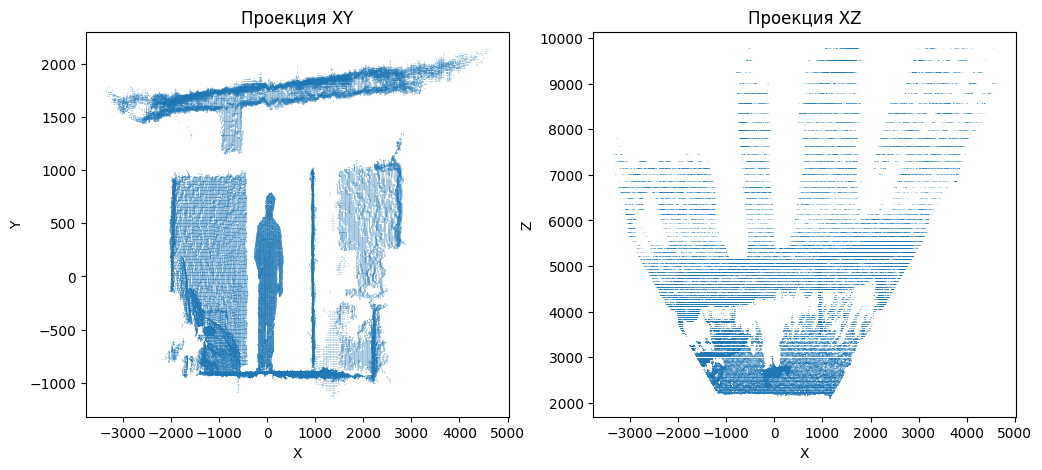

In [94]:
if depthmap is not None:
    plot_3d(points_3d, skip=20)
    plot_projections(points_3d)

# Проверка обратного преобразования

In [95]:
def pointcloud_to_depth(points, shape):
    h, w = shape
    restored = np.zeros(shape, dtype=np.uint16)

    # Обратные формулы
    u = np.round(CX + points[:,0] * FX / points[:,2]).astype(int)
    v = np.round(CY - points[:,1] * FY / points[:,2]).astype(int)

    # Проверка границ
    valid = (u >= 0) & (u < w) & (v >= 0) & (v < h)

    restored[v[valid], u[valid]] = points[valid, 2]
    return restored

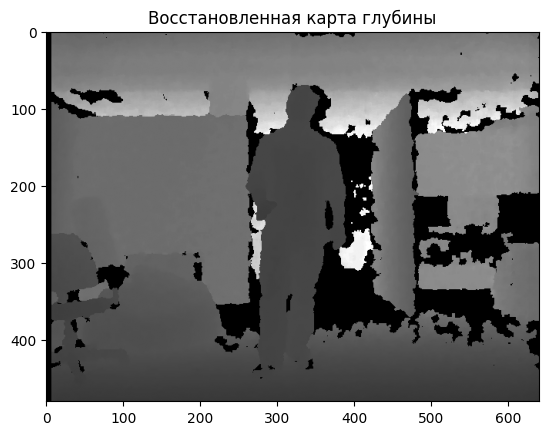

In [96]:
if depthmap is not None:
    restored_map = pointcloud_to_depth(points_3d, depthmap.shape)
    plt.imshow(restored_map, cmap='gray')
    plt.title("Восстановленная карта глубины")
    plt.show()

# RANSAC (Поиск прямой)

In [97]:
def generate_data():
    # Истинная прямая
    x = np.linspace(0, 10, 50)
    y = 0.5 * x + 1
    points = np.stack([x, y], axis=1)

    # Добавляем шум
    points += np.random.normal(0, 0.1, points.shape)

    # Добавляем выбросы (outliers)
    outliers = np.random.uniform(low=[0,0], high=[10,10], size=(20, 2))

    return np.concatenate([points, outliers])

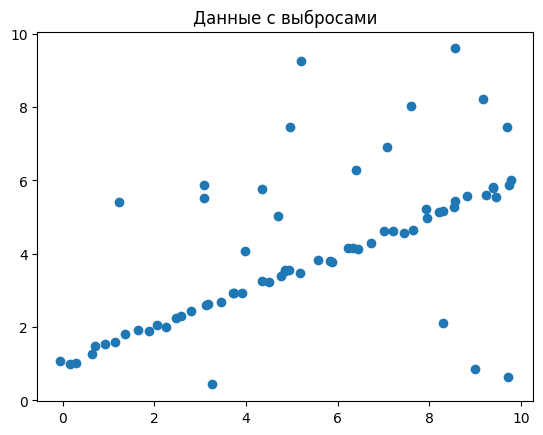

In [98]:
data = generate_data()
plt.scatter(data[:,0], data[:,1], label='Данные')
plt.title("Данные с выбросами")
plt.show()

# Сравнение методов

## 1. Линейная регрессия (чувствительна к выбросам)

In [99]:
reg = LinearRegression().fit(data[:,0].reshape(-1,1), data[:,1])
x_line = np.array([0, 10])
y_lr = reg.predict(x_line.reshape(-1,1))

## 2. RANSAC Реализация

In [100]:
def fit_ransac(points, iterations=1000, threshold=0.5):
    best_line = None # (k, b)
    best_count = 0

    for _ in range(iterations):
        # Выбираем 2 случайные точки
        idx = np.random.choice(len(points), 2, replace=False)
        p1, p2 = points[idx]

        if p2[0] == p1[0]: continue # пропускаем вертикальные

        # Параметры прямой y = kx + b
        k = (p2[1] - p1[1]) / (p2[0] - p1[0])
        b = p1[1] - k * p1[0]

        # Считаем расстояние от точек до прямой
        # |kx - y + b| / sqrt(k^2 + 1)
        dists = np.abs(k*points[:,0] - points[:,1] + b) / np.sqrt(k**2 + 1)

        # Считаем inliers (точки внутри порога)
        inliers = np.sum(dists < threshold)

        if inliers > best_count:
            best_count = inliers
            best_line = (k, b)

    return best_line

In [101]:
k_ransac, b_ransac = fit_ransac(data)
y_ransac = k_ransac * x_line + b_ransac

### Визуализация итогов

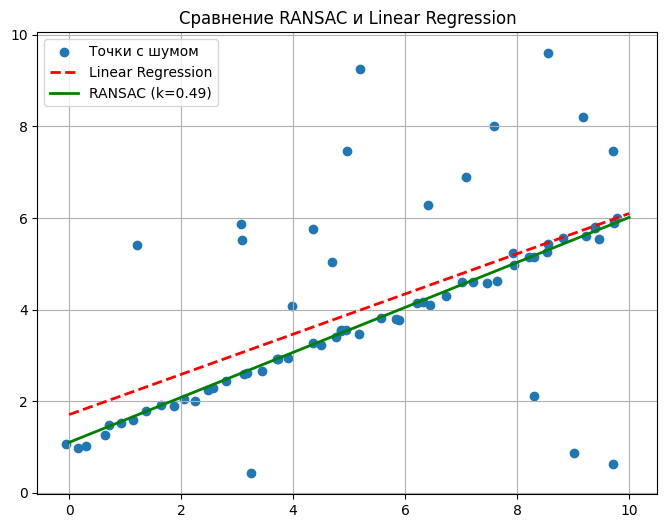

In [102]:
plt.figure(figsize=(8,6))
plt.scatter(data[:,0], data[:,1], label='Точки с шумом')
plt.plot(x_line, y_lr, 'r--', linewidth=2, label='Linear Regression')
plt.plot(x_line, y_ransac, 'g-', linewidth=2, label=f'RANSAC (k={k_ransac:.2f})')
plt.legend()
plt.title("Сравнение RANSAC и Linear Regression")
plt.grid(True)
plt.show()